In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import Word2Vec,StringIndexer,CountVectorizer,HashingTF, IDF
from pyspark.ml.classification import NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler
# !pip3 install --user chart_studio
import chart_studio.plotly as ply
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
import numpy as np
import subprocess

ss = SparkSession.builder.master("local[*]").appName("ddam-8_STEP-4_visualisation").getOrCreate()

In [2]:
def save(df, filename):
    filepath = f"hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/{filename}"
    subprocess.call(["hadoop", "fs", "-rm", "-r", filepath])
    df.write.csv(filepath, header = True)

In [3]:
def split_text(df, colname):
    return df.withColumn(colname, F.split(F.lower(F.col(colname)), " ")).dropna()

In [4]:
twitter_df = ss.read.csv("hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/df_Model.csv", sep=",", quote='"', header=True, escape='"', multiLine=True)
trump_df = ss.read.csv("hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/df_Trump.csv", sep=",", quote='"', header=True, multiLine=True)
biden_df = ss.read.csv("hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/df_Biden.csv", sep=",", quote='"', header=True, multiLine=True)

twitter_df = split_text(twitter_df,'text')
twitter_df = StringIndexer(inputCol="sentiment", outputCol="label").fit(twitter_df).transform(twitter_df)
trump_df = trump_df.withColumn('text', F.col('tweet'))
trump_df = split_text(trump_df,'text')
biden_df = biden_df.withColumn('text', F.col('tweet'))
biden_df = split_text(biden_df,'text')

In [5]:
f_len = 400
vec_model = CountVectorizer(inputCol="text", outputCol="features", vocabSize=f_len, minDF=5).fit(twitter_df)
twitter_df = vec_model.transform(twitter_df)
model = MultilayerPerceptronClassifier(layers=[f_len, int((f_len+3)/2), 3], solver='l-bfgs',
                                       featuresCol='features', labelCol='label').fit(twitter_df)

In [6]:
trump_df = model.transform(vec_model.transform(trump_df)) \
                .select(['created_at', 'likes', 'lat', 'long', 'prediction', 'city'])
biden_df = model.transform(vec_model.transform(biden_df)) \
                .select(['created_at', 'likes', 'lat', 'long', 'prediction', 'city'])

In [7]:
def plotize(df):
    return df.withColumn('prediction', F.when(F.col('prediction')==2., -1.).otherwise(F.col('prediction'))) \
             .withColumn('created_at', F.substring('created_at', 0, 10)) \
             .filter(F.col("created_at").startswith("2020-")) \
             .groupBy('created_at').agg(F.mean('prediction').alias('sentiment')).orderBy('created_at')

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Biden'}, xlabel='created_at'>

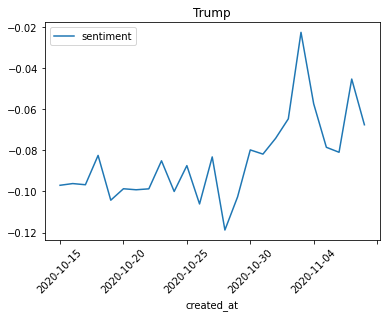

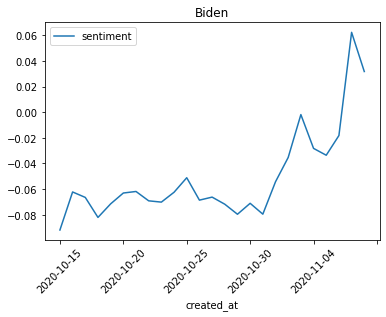

In [8]:
plotize(trump_df).toPandas().plot(x='created_at', y='sentiment',title = 'Trump', rot = 45)
plotize(biden_df).toPandas().plot(x='created_at', y='sentiment',title = 'Biden', rot = 45)

In [7]:
save(trump_df.withColumn('prediction', F.when(F.col('prediction')==2., -1.).otherwise(F.col('prediction'))),'trump.csv')
save(biden_df.withColumn('prediction', F.when(F.col('prediction')==2., -1.).otherwise(F.col('prediction'))),'biden.csv')
# I used these 2 files to making timeline map's through microstrategy desktop

### Geospatially clustering

In [9]:
import folium

color_dict = {0:"blue", 1: "red", 2: "green", 3: "purple", 4:"orange", 5:"gray", 6:"black", 7:"white",8:"darkblue",9:"beige"}

def plot_map(cluster_data): 
    m = folium.Map([45.42978, 12.35715], zoom_start = 0)
    
    for i in range(0,len(cluster_data)):
        cluster_id = cluster_data[i][0]
        likes = cluster_data[i][1][2]
        lat_lon = (cluster_data[i][1][0], cluster_data[i][1][1])
        folium.Marker(lat_lon, popup="Cluster:{0}\nlikes:{1}".format(cluster_id, likes), icon=folium.Icon(color=color_dict[cluster_id], icon='info-sign')).add_to(m)
    return m

In [7]:
trump_geo = trump_df.drop('created_at','prediction','city').sample(0.01)
biden_geo = biden_df.drop('created_at','prediction','city').sample(0.01)

In [8]:
trump_rdd = trump_geo.rdd.map(lambda t: (float(t[1]), float(t[2]),float(t[0])))
biden_rdd = biden_geo.rdd.map(lambda t: (float(t[1]), float(t[2]), float(t[0])))

TRUMP

In [12]:
# select the features
trump_geo_sentiment = trump_rdd.map(lambda t: (t[0], t[1],t[2]))

# train
model = KMeans.train(trump_geo_sentiment, k=2, initializationMode="random")

In [13]:
# assign to the clusters

cluster_data = trump_rdd.map(lambda x: (model.predict((x[0],x[1],x[2])), x)) \
            .collect()

plot_map(cluster_data)

BIDEN

In [14]:
# select the features
biden_geo_sentiment = biden_rdd.map(lambda t: (t[0], t[1],t[2]))

# train
model = KMeans.train(biden_geo_sentiment, k=2, initializationMode="random")

In [15]:
# assign to the clusters

cluster_data = biden_rdd.map(lambda x: (model.predict((x[0],x[1],x[2])), x)) \
            .collect()

plot_map(cluster_data)